In [2]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import os


os.chdir("..")
from data.loader import load_training, load_validation, n_freq, n_time, n_classes

In [26]:
force_cpu = True


if t.cuda.is_available() and not force_cpu:
    device = t.device("cuda")
else:
    device = t.device("cpu")


X_map = lambda X: t.from_numpy(X).to(dtype=t.float)
y_map = lambda y: t.from_numpy(y).to(dtype=t.uint8)
loader_map = lambda data: DataLoader(
    dataset=data,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory="cuda" == device,
)


X_train, y_train = load_training()
X_val, y_val = load_validation()

X_train, X_val = map(X_map, (X_train, X_val))
y_train, y_val = map(y_map, (y_train, y_val))


data_train = TensorDataset(X_train, y_train)
data_val = TensorDataset(X_val, y_val)

loader_train, loader_val = map(loader_map, (data_train, data_val))


n_train = len(X_train)
n_val = len(X_val)

In [34]:
class NaiveModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(32, 32, 3),
            nn.Conv1d(32, 16, 3),
            nn.Tanh(),
            nn.AvgPool1d(3),
            nn.Conv1d(16, 4, 1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(120, 64),
            nn.Tanh(),
            nn.Linear(64, n_classes)
        )


    def forward(self, X: t.Tensor) -> t.Tensor:
        return self.model(X)


learning_rate = 1e-4
weight_decay = 1e-4
n_epochs = 20

model = NaiveModel().to(device)


model.train()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

acc_running = 0

for epoch in (bar:=trange(n_epochs)):
    for x, y in loader_train:
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)

        acc = (y_pred.argmax(dim=1) == y).sum() / y.size(0)
        acc_running += 0.05 * (acc.item() - acc_running)
        bar.set_postfix(acc=f"{acc_running:.2f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
model.eval()

acc_running = 0

for i, (x, y) in (bar:=tqdm(enumerate(loader_val, 1), leave=False)):
    x = x.to(device)
    y = y.to(device)

    y_pred = model(x)

    acc = (y_pred.argmax(dim=1) == y).sum() / y.size(0)

    acc_running += 1/i * (acc.item() - acc_running)
    bar.set_postfix(acc=f"{acc_running:.2f}")


print(acc_running)

0it [00:00, ?it/s]

0.7393812190240887


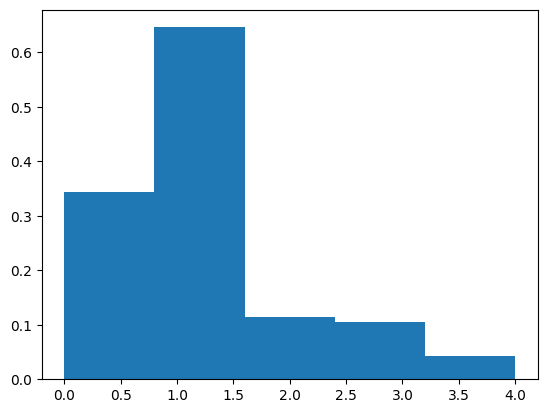

In [21]:
plt.hist(y_train, bins=5, density=True)
plt.show()